# **CIS 5450 Final Project: Flight Cancellations**

Adam Gorka, Andrew Lukashchuk, Hassan Rizwan


# **Part I:** Introduction and Setup

In our project, we intend to study data on flights in 2022. With this data, we want to find relationships on the cancellation of flights between various possible factors impacting the cancellation, including the flight date, airline, origin and destination city, distance, and year. It will be possible to see if there are any significant relationships between these factors and the flight being canceled, especially given the large number of entries in the dataset. Having a high number of data entries will prove useful in finding accurate relationships between the many different data points.

First, run the following cells to set up the notebook.

In [ ]:
%%capture
!apt update
!pip install kaggle
!pip install tensorflow

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import plotly.express as px
from google.colab import drive
import os

# **Part II:** Preprocessing

We are using one Parquet for this project, `Combined_Flights_2022.parquet` from a Kaggle [dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022?select=Combined_Flights_2022.parquet). The dataset contains 61 columns and over 4 million flight entries.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Create the kaggle directory
!mkdir ~/.kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download robikscube/flight-delay-dataset-20182022 -f Combined_Flights_2022.parquet

['Combined_Flights_2022.parquet.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
# Only run once

# Unzip folder in Colab content folder
!unzip /content/Combined_Flights_2022.parquet.zip

Archive:  /content/Combined_Flights_2022.parquet.zip
replace Combined_Flights_2022.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load data into Pandas DataFrame
df = pd.read_parquet('Combined_Flights_2022.parquet')

# Although null values would typically be dropped now, we cannot do so as the Cancelled and Diverted Flights have other attributes set as null

In [ ]:
# Print out the first five rows
df.head(5)

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,False,False,1133,1123.0,0.0,-10.0,...,1140.0,1220.0,8.0,1245,-17.0,0.0,-2.0,1200-1259,1,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,False,False,732,728.0,0.0,-4.0,...,744.0,839.0,9.0,849,-1.0,0.0,-1.0,0800-0859,2,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1529,1514.0,0.0,-15.0,...,1535.0,1622.0,14.0,1639,-3.0,0.0,-1.0,1600-1659,2,0
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,False,False,1435,1430.0,0.0,-5.0,...,1446.0,1543.0,4.0,1605,-18.0,0.0,-2.0,1600-1659,2,0
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,False,False,1135,1135.0,0.0,0.0,...,1154.0,1243.0,8.0,1245,6.0,0.0,0.0,1200-1259,2,0


In [ ]:
# See basic dataframe type info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4078318 entries, 0 to 590541
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[ns]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               int64         
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                      

In [ ]:
# Basic Dataframe Summary
df.describe()

,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,...,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,DistanceGroup,DivAirportLandings
count,4.078318e+06,3.957885e+06,3.957823e+06,3.957823e+06,3.954079e+06,3.944916e+06,3.944916e+06,4.078318e+06,3.944916e+06,4.078318e+06,...,3.955652e+06,3.955652e+06,3.954076e+06,3.954076e+06,4.078318e+06,3.944916e+06,3.944916e+06,3.944916e+06,4.078318e+06,4.078318e+06
mean,1.329587e+03,1.334374e+03,1.601494e+01,1.309049e+01,1.457886e+03,1.578307e+01,1.110075e+02,1.413211e+02,1.358624e+02,7.978657e+02,...,1.697375e+01,1.356576e+03,1.455073e+03,7.894387e+00,1.486058e+03,7.528486e+00,2.164715e-01,-6.256103e-02,3.663516e+00,3.685098e-03
std,4.904801e+02,5.056219e+02,5.231498e+01,5.332016e+01,5.431841e+02,5.198424e+01,6.996246e+01,7.179635e+01,7.185501e+01,5.914742e+02,...,9.495407e+00,5.075580e+02,5.378428e+02,6.663118e+00,5.185078e+02,5.524625e+01,4.118393e-01,2.487442e+00,2.320848e+00,1.141331e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,-7.800000e+01,1.000000e+00,0.000000e+00,8.000000e+00,-4.800000e+01,1.400000e+01,3.100000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+02,0.000000e+00,-2.000000e+00,1.000000e+00,0.000000e+00
25%,9.140000e+02,9.170000e+02,0.000000e+00,-5.000000e+00,1.046000e+03,0.000000e+00,6.000000e+01,8.900000e+01,8.300000e+01,3.680000e+02,...,1.100000e+01,9.320000e+02,1.044000e+03,4.000000e+00,1.103000e+03,-1.400000e+01,0.000000e+00,-1.000000e+00,2.000000e+00,0.000000e+00
50%,1.320000e+03,1.325000e+03,0.000000e+00,-2.000000e+00,1.500000e+03,0.000000e+00,9.400000e+01,1.240000e+02,1.190000e+02,6.430000e+02,...,1.500000e+01,1.338000e+03,1.456000e+03,6.000000e+00,1.513000e+03,-5.000000e+00,0.000000e+00,-1.000000e+00,3.000000e+00,0.000000e+00
75%,1.735000e+03,1.744000e+03,1.100000e+01,1.100000e+01,1.914000e+03,1.000000e+01,1.410000e+02,1.710000e+02,1.670000e+02,1.035000e+03,...,1.900000e+01,1.758000e+03,1.909000e+03,9.000000e+00,1.920000e+03,1.000000e+01,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00
max,2.359000e+03,2.400000e+03,7.223000e+03,7.223000e+03,2.400000e+03,7.232000e+03,7.270000e+02,6.900000e+02,7.640000e+02,5.095000e+03,...,2.210000e+02,2.400000e+03,2.400000e+03,2.900000e+02,2.359000e+03,7.232000e+03,1.000000e+00,1.200000e+01,1.100000e+01,9.000000e+00


In the dataframe info, we see that DayOfWeek is of type 'int64'. We'll start by mapping this to a string of type object for simplicity.

In [ ]:
# Check that the current DayOfWeek column includes all 7 days of the week and see if it uses 0-6 or 1-7
df['DayOfWeek'].unique()

array([1, 7, 6, 5, 2, 3, 4])

In [ ]:
# Given that it uses integers 1-7, map accordingly
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df['DayOfWeekName'] = df['DayOfWeek'].map(day_mapping)

We also see that the columns Cancelled and Diverted are of type bool, so we will map them to integers to make calculations on them easier.

In [ ]:
df[['Cancelled', 'Diverted']] = df[['Cancelled', 'Diverted']].astype(int)

We want to look at the years covered in our DataFrame to see if it will have any impact on our analysis.

In [ ]:
# Display all unique years in DataFrame

df['Year'].unique()

array([2022])

In [ ]:
# Because it is only 2022, we can drop the column 'Year'

df = df.drop(columns=['Year'])

We will now drop more columns which are redundant and/or we will not be looking at in our analysis.



In [ ]:
dropping = ['CRSDepTime', 'DepDelay', 'CRSElapsedTime', 'ActualElapsedTime', 'Operated_or_Branded_Code_Share_Partners',
                   'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline',
                   'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'OriginCityMarketID', 'OriginStateFips',
                   'OriginWac', 'DestCityMarketID', 'DestStateFips', 'DestWac', 'DepDel15', 'DepartureDelayGroups',
                   'DepTimeBlk', 'WheelsOff', 'WheelsOn', 'CRSArrTime', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk',
                   'DistanceGroup', 'TaxiOut', 'TaxiIn', 'DivAirportLandings', 'DestAirportID', 'DestAirportSeqID',
                   'OriginStateName', 'DestStateName', 'Marketing_Airline_Network', 'Tail_Number', 'OriginAirportSeqID',
                   'OriginAirportID', 'ArrDelay', 'Flight_Number_Operating_Airline', 'Quarter', 'Operating_Airline']

df = df.drop(columns=dropping)

In [ ]:
# Let's view the DataFrame's info after our preprocessing and modifications

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4078318 entries, 0 to 590541
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   FlightDate       datetime64[ns]
 1   Airline          object        
 2   Origin           object        
 3   Dest             object        
 4   Cancelled        int64         
 5   Diverted         int64         
 6   DepTime          float64       
 7   DepDelayMinutes  float64       
 8   ArrTime          float64       
 9   ArrDelayMinutes  float64       
 10  AirTime          float64       
 11  Distance         float64       
 12  Month            int64         
 13  DayofMonth       int64         
 14  DayOfWeek        int64         
 15  OriginCityName   object        
 16  OriginState      object        
 17  DestCityName     object        
 18  DestState        object        
 19  DayOfWeekName    object        
dtypes: datetime64[ns](1), float64(6), int64(5), object(8)
memory usage: 6

# **Part III:** Exploratory Analysis

Now that we a general idea of the structure of the dataframe, we want to begin by performing some Exploratory Analysis on the data to see what information the data can give us.

First we'll make a correlation matrix to see if any relationships or correlations between the various attributes stick out.

<ipython-input-18-9e04f0e6e55c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


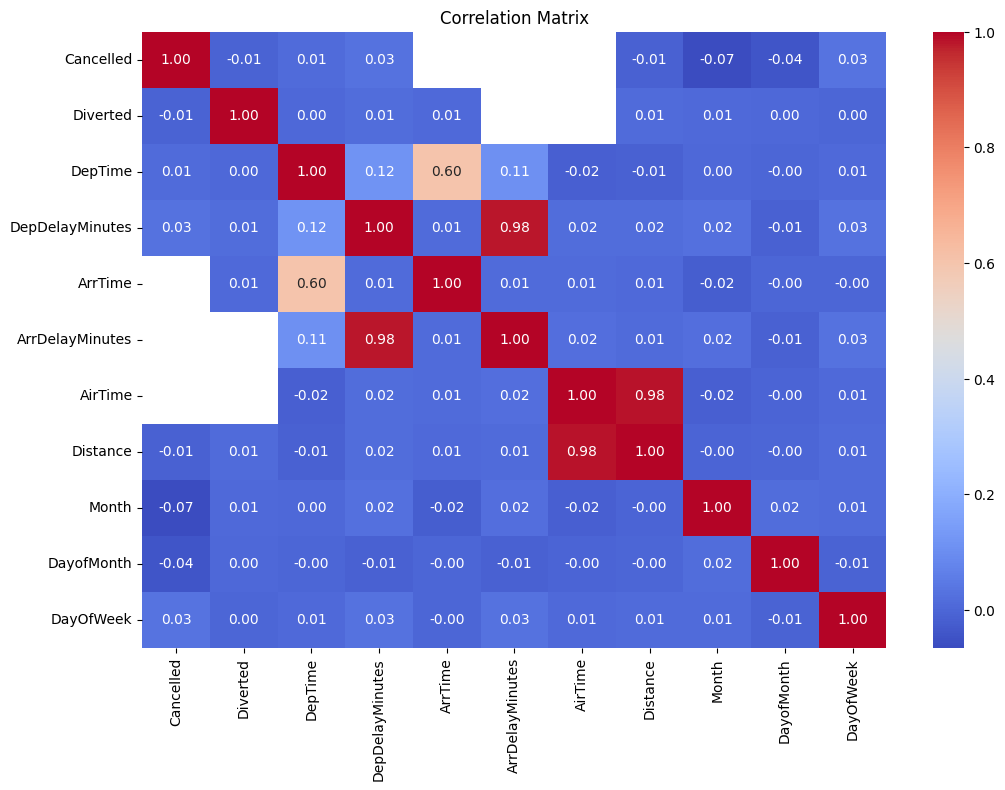

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

We can note that two variables stick out for being highly correlated, the arrival delay and departure delay, which is not surprising given that it can be expected that if a flight departs late it will arrive late, as well as the converse. Given the 0.98 correlation between arrival delay and departure delay and the 0.02 correlation between air time and arrival delay, we can assume that delays will not be caused due to the flight lasting longer, but being mainly due to late departures. We will therefore remove the arrival delay columns and look chiefly and departure delays in our analysis.



In [ ]:
# Drop columns related to arrival delay and arrival time
df = df.drop(columns=['ArrTime', 'ArrDelayMinutes'])

Now that all of the redundant columns are removed, we want to more closely examine all of the numerical columns in the graph by displaying histograms for all of them.

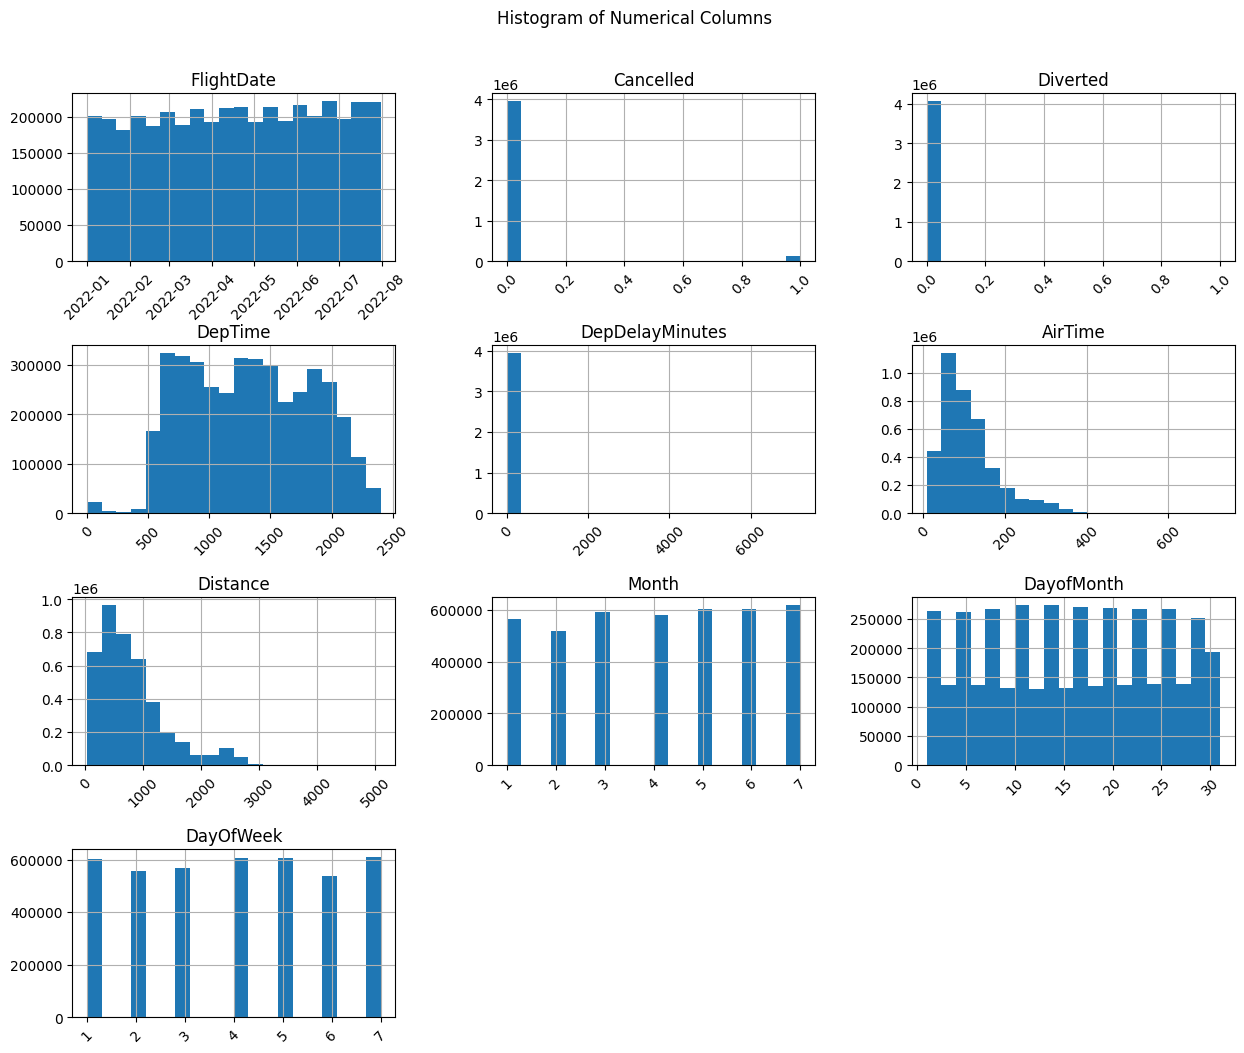

In [ ]:
# Display histograms of numerical columns
df.hist(figsize=(15, 12), bins=20)
for ax in plt.gcf().get_axes():
    ax.tick_params(axis='x', rotation=45)
plt.suptitle("Histogram of Numerical Columns", y=0.95)
plt.subplots_adjust(hspace=0.5)
plt.show()

Now that we have performed analysis on the various numerical columns in the DataFrame, we want to more closely examine the categorical columns and see if there are any obvious trends or correlations.

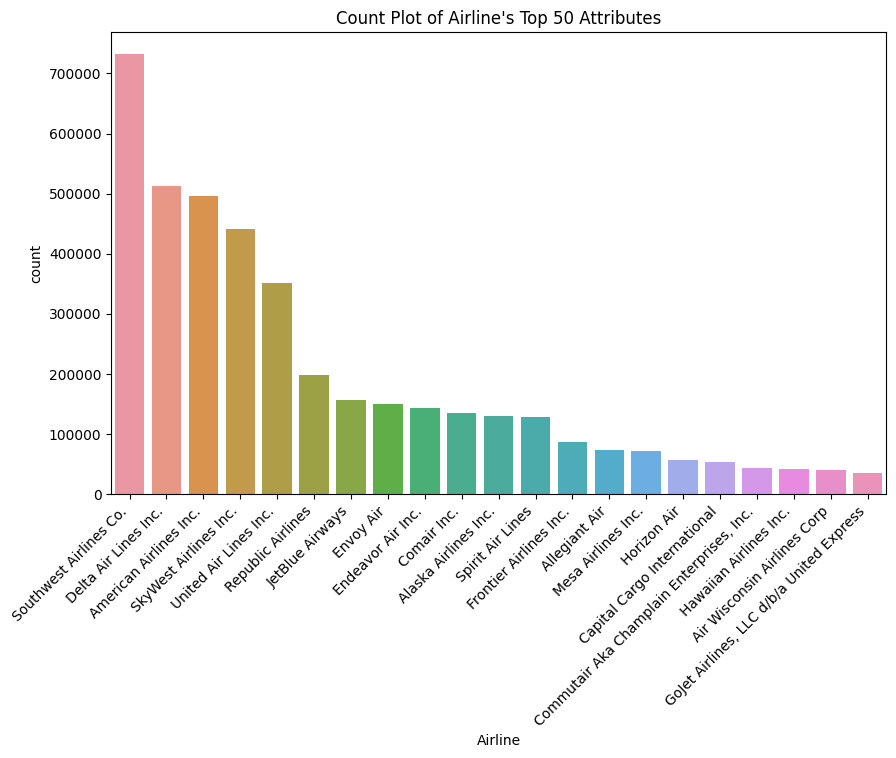

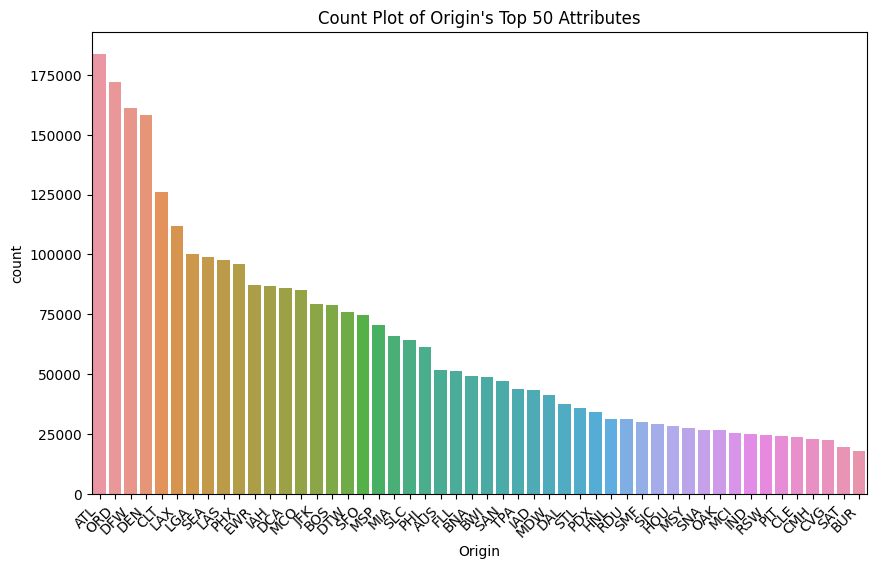

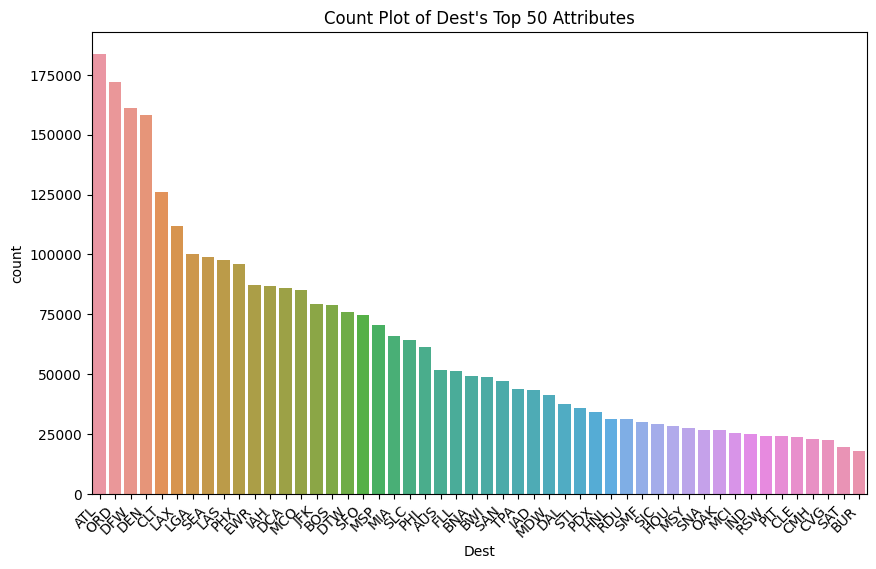

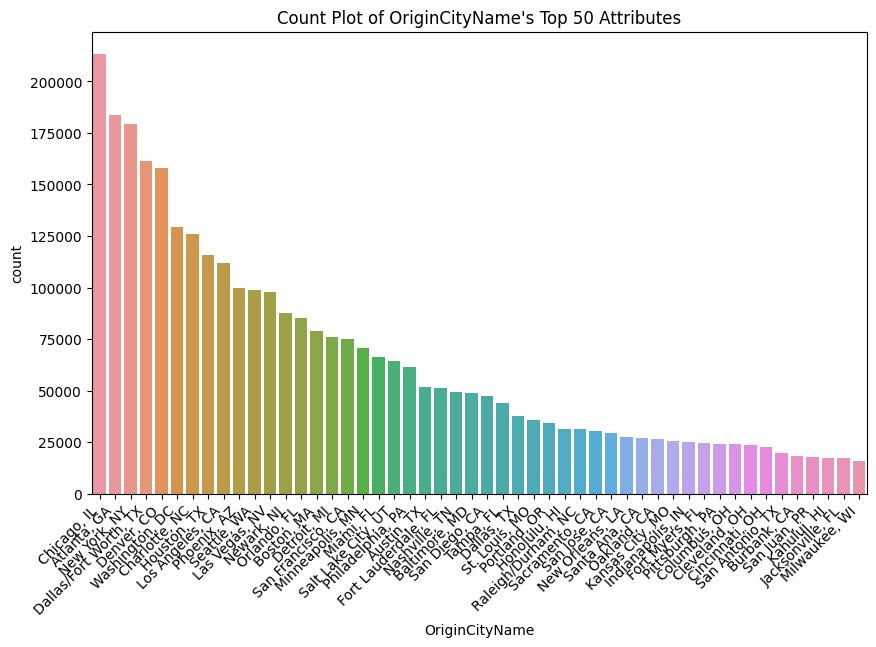

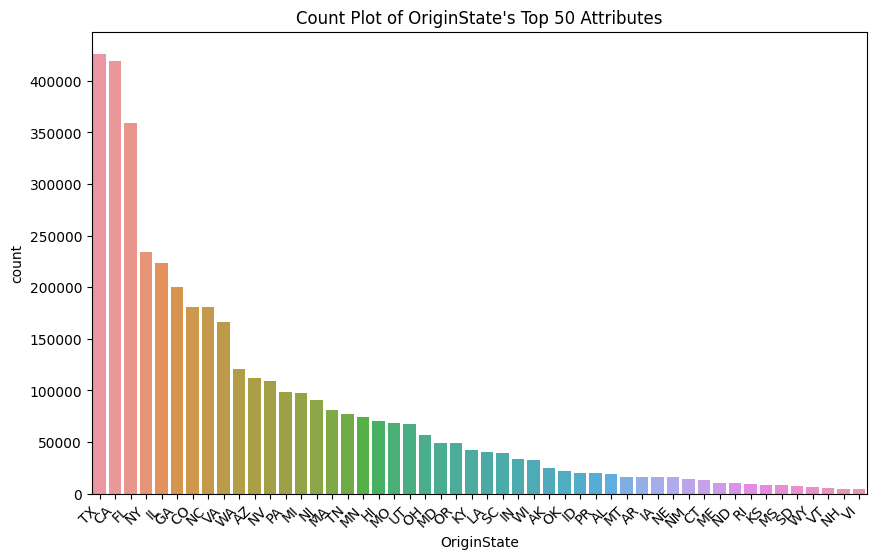

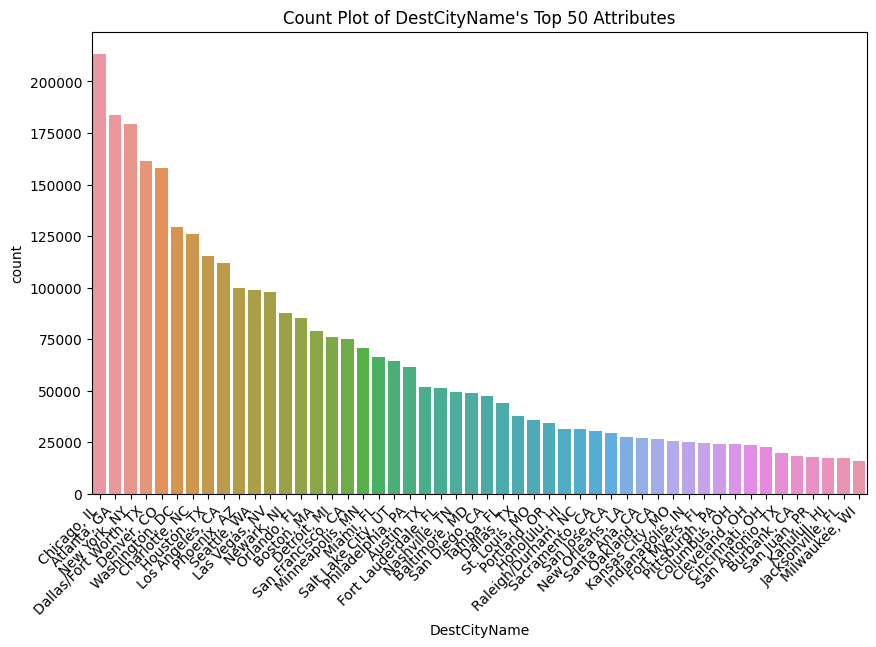

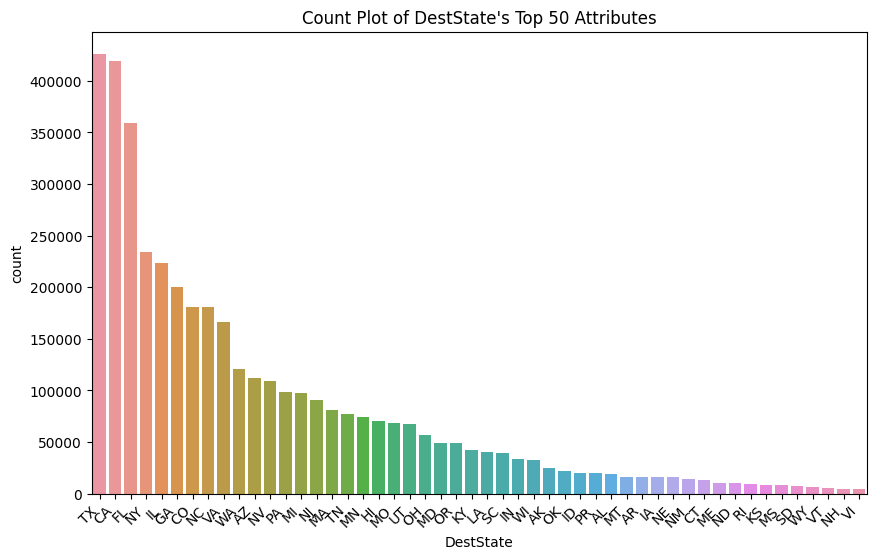

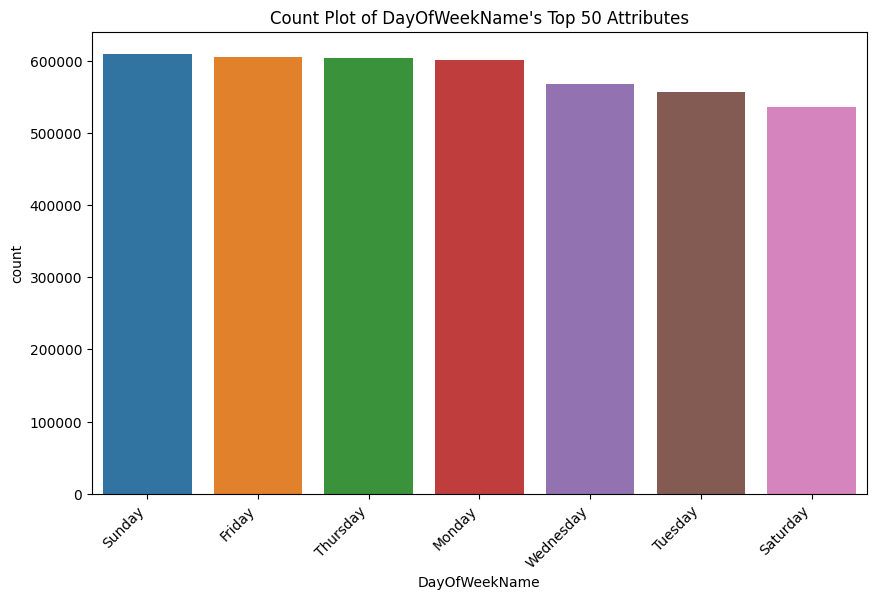

In [ ]:
# Display count plots of categorical columns with top 50 values
categorical_columns = df.select_dtypes(include=["object"]).columns
for column in categorical_columns:
    # Plot top 50  values for column
    top_50_values = df[column].value_counts().nlargest(50).index
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=df[df[column].isin(top_50_values)], order=top_50_values)
    plt.title(f"Count Plot of {column}'s Top 50 Attributes")
    plt.xticks(rotation=45, ha="right")
    plt.show()

Now that we have closely examined both the numerical and categorical attributes of the DataFrame, we want to start examining possible relationships that may appear and visualize them.

Because we will be examining the cancellation status in this notebook, we can start by looking at the amount of cancelled flights relative to the amount of flights that were not cancelled.

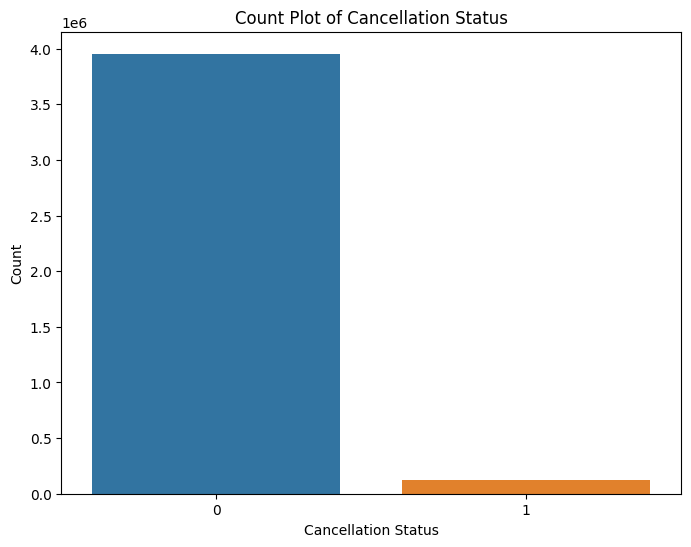

In [ ]:
# Count plot of cancellation status
plt.figure(figsize=(8, 6))
sns.countplot(x='Cancelled', data=df)
plt.title('Count Plot of Cancellation Status')
plt.xlabel('Cancellation Status')
plt.ylabel('Count')
plt.show()

We can note the very small amount of cancelled flights compared to total flights. Now, we will do the same plot, but for diverted flights.

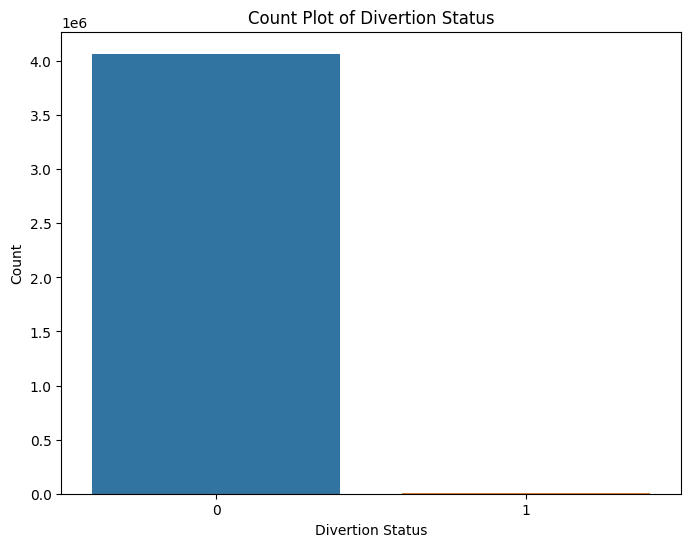

In [ ]:
# Count plot of divertion status
plt.figure(figsize=(8, 6))
sns.countplot(x='Diverted', data=df)
plt.title('Count Plot of Divertion Status')
plt.xlabel('Divertion Status')
plt.ylabel('Count')
plt.show()

We can note how much astronomically smaller the amount of diverted flights is when compared to cancelled flights. Because it is such a small amount of data compared to cancelled and delayed flights, we will drop the column and focus on flight cancellations and delays in our analysis.

In [ ]:
# Drop Diverted column from DataFrame
df = df.drop(columns=['Diverted'])

Now, we are going to visualize the relationship between the date and the average delay for that date. This would be able to help show us any obvious seasonality or patterns if they exist.

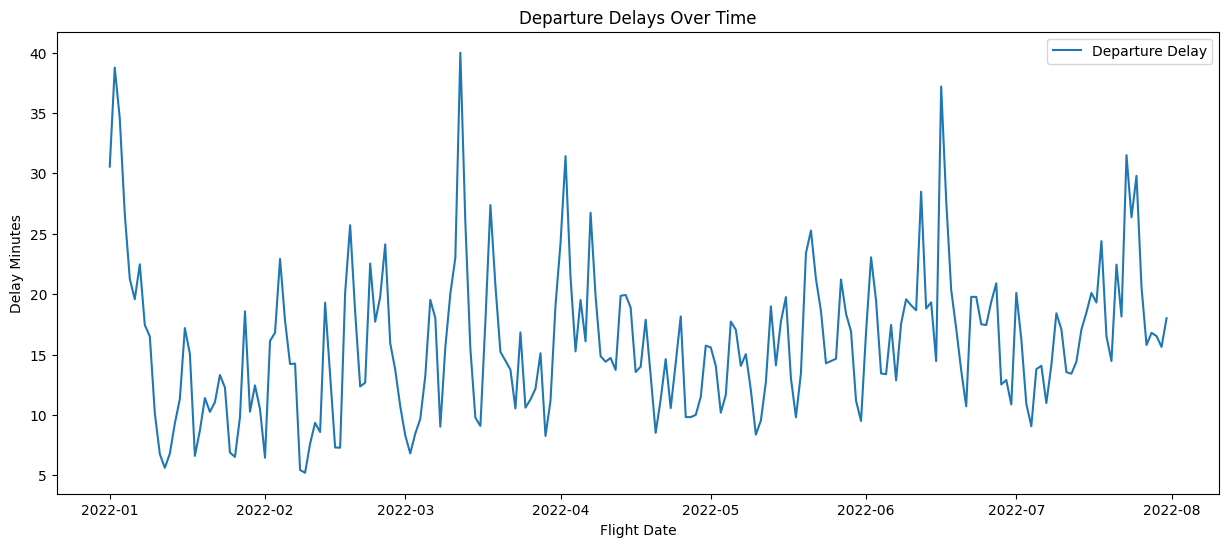

In [ ]:
# Aggregate average delay by flight date
aggregated_df = df.groupby('FlightDate')['DepDelayMinutes'].mean().reset_index()

# Create lineplot
plt.figure(figsize=(15, 6))
sns.lineplot(x='FlightDate', y='DepDelayMinutes', data=aggregated_df, label='Departure Delay')
plt.title('Departure Delays Over Time')
plt.xlabel('Flight Date')
plt.ylabel('Delay Minutes')
plt.legend()
plt.show()

We can note that the data seems to spike a lot, let's delve closer and see if there is any relationship between the day of the week and delay by plotting the average delay for each of the week.

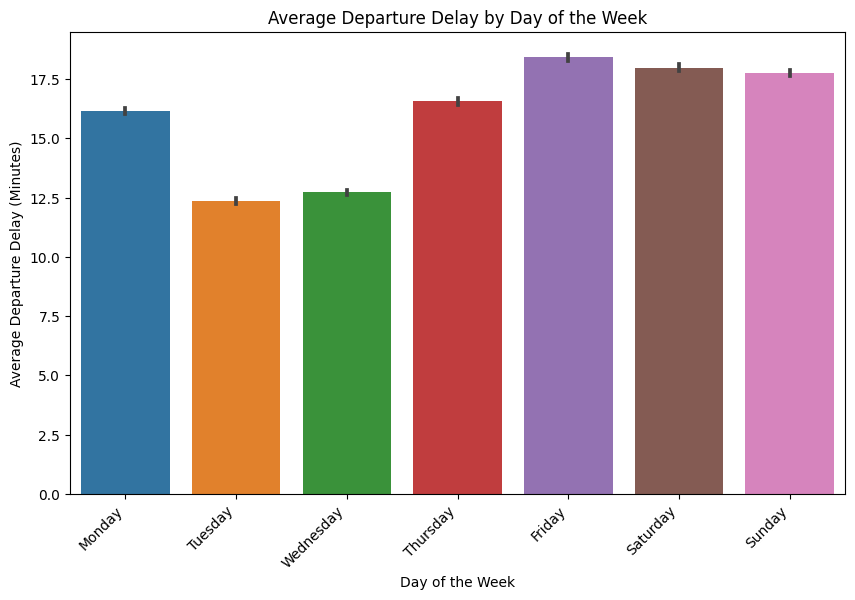

In [ ]:
# Bar plot of average departure delay by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeekName', y='DepDelayMinutes', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Departure Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Departure Delay (Minutes)')
plt.xticks(rotation=45, ha="right")
plt.show()

We can see that there appears to be some relation with higher average delays on weekends. This is something we can look further into in our modeling.

Now, we want to show the average delay by airline.

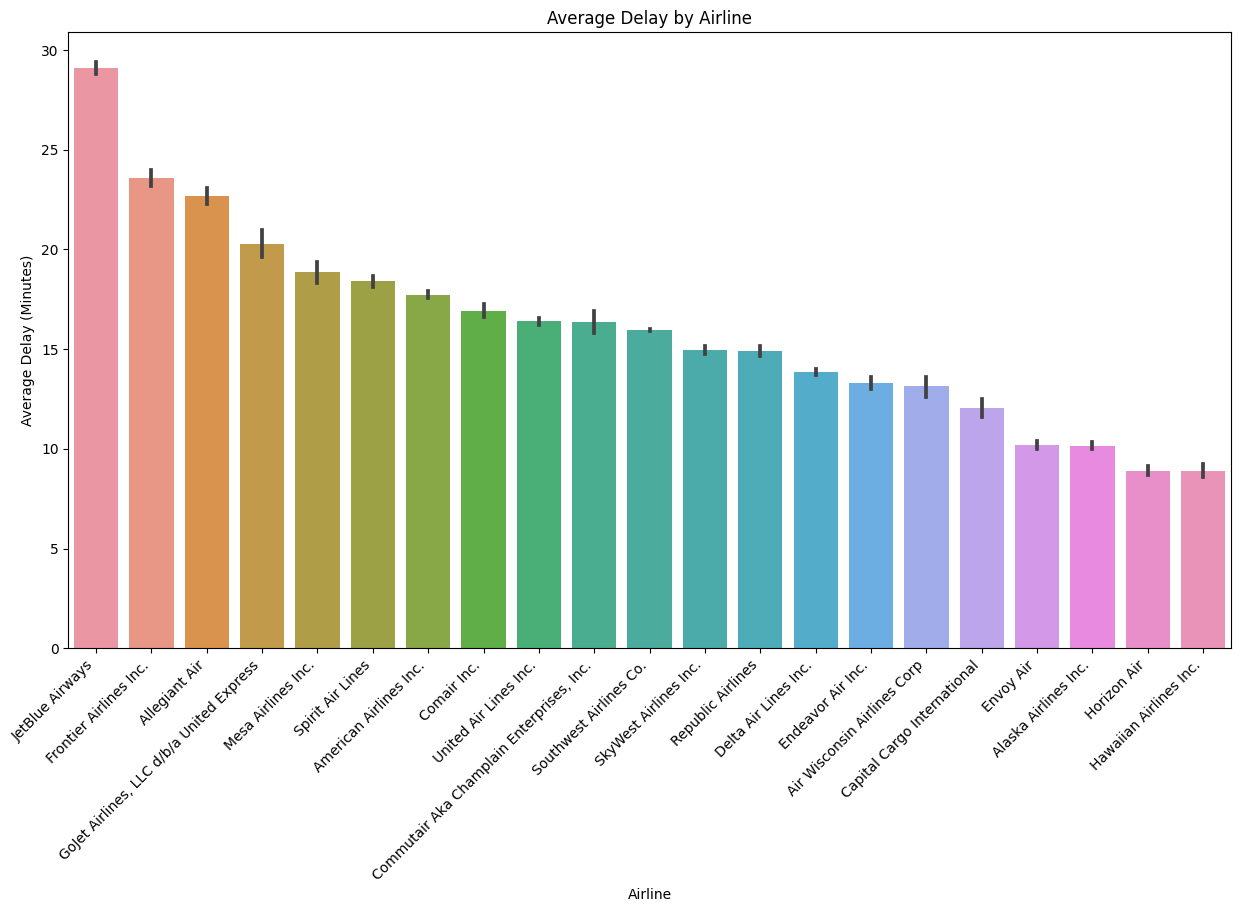

In [ ]:
# Bar plot of average delay by airline
plt.figure(figsize=(15, 8))
sns.barplot(x='Airline', y='DepDelayMinutes', data=df, order=df.groupby('Airline')['DepDelayMinutes'].mean().sort_values(ascending=False).index)
plt.title('Average Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45, ha="right")
plt.show()

We start to see much more discrepencies here, with budget airlines like JetBlue, Frontier, and Allegiant being notably higher than the rest of the airlines.

Now, we will examine the same relationships we just did, but for cancellations.

First, we are going to visualize the relationship between the date and the cancellation rate for that date. This would be able to help show us any obvious seasonality or patterns if they exist.

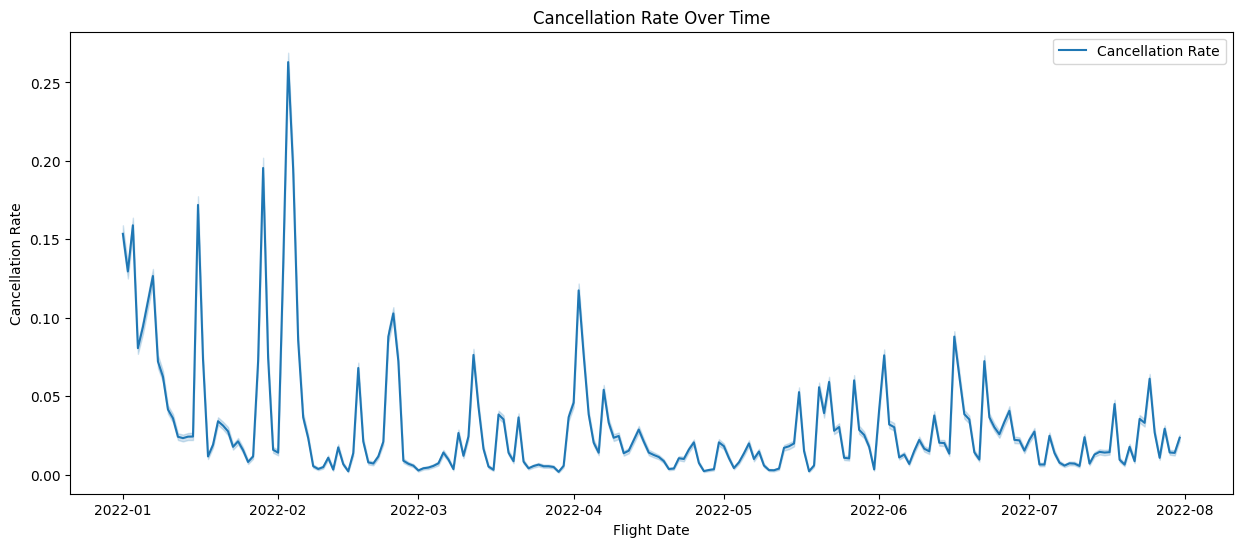

In [ ]:
# Create lineplot
plt.figure(figsize=(15, 6))
sns.lineplot(x='FlightDate', y='Cancelled', data=df, label='Cancellation Rate')
plt.title('Cancellation Rate Over Time')
plt.xlabel('Flight Date')
plt.ylabel('Cancellation Rate')
plt.legend()
plt.show()

We can note that the data seems to spike a lot, let's delve closer and see if there is any relationship between the day of the week and delay by plotting the cancellation rate for each of the week.

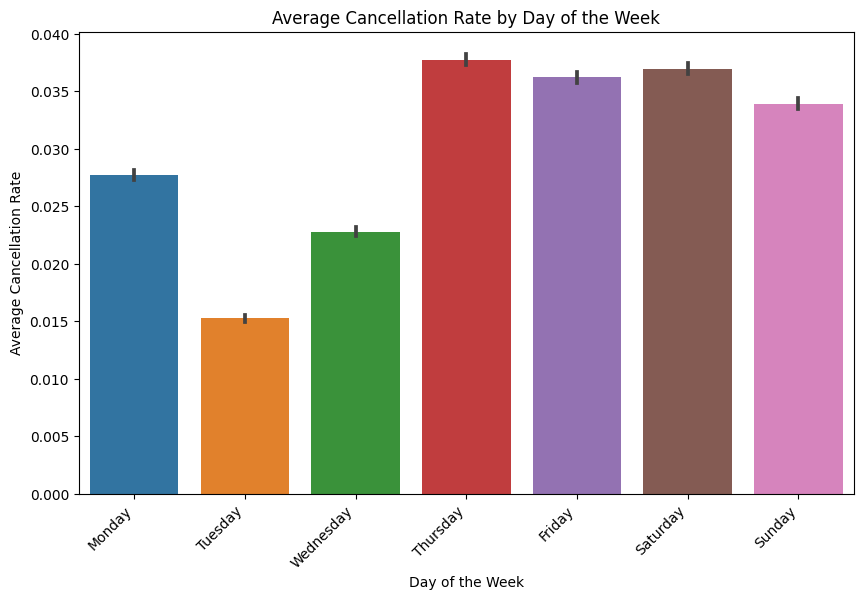

In [ ]:
# Bar plot of average cancellation rate by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeekName', y='Cancelled', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Cancellation Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Cancellation Rate')
plt.xticks(rotation=45, ha="right")
plt.show()

We can see that there appears to be some relation with higher average cancellation rates on Thursdays and weekends. This is something we can look further into in our modeling.

Now, we want to show the average cancellation rate by airline.

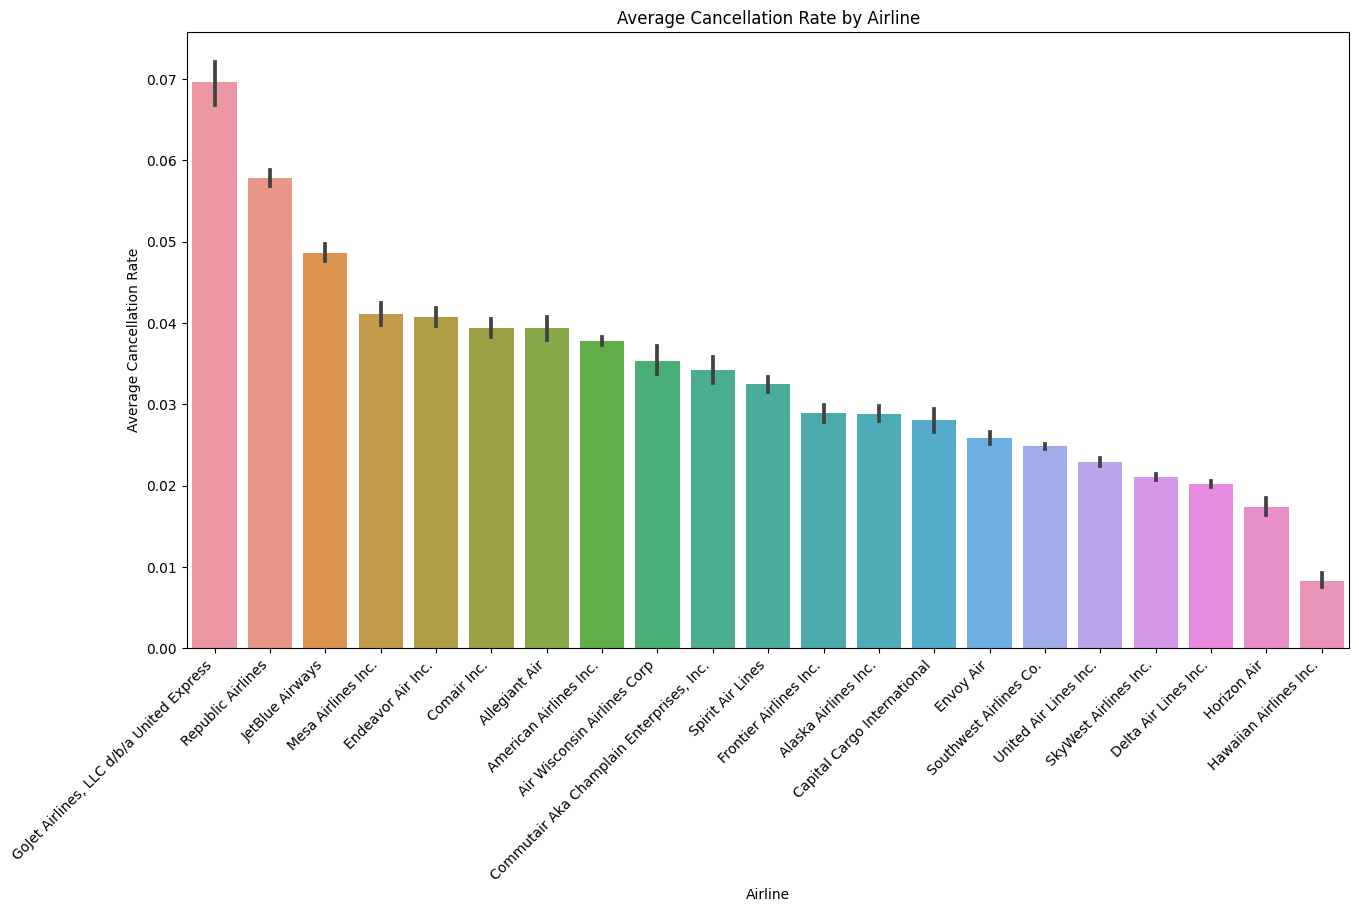

In [ ]:
# Bar plot of average cancellation rate by airline
plt.figure(figsize=(15, 8))
sns.barplot(x='Airline', y='Cancelled', data=df, order=df.groupby('Airline')['Cancelled'].mean().sort_values(ascending=False).index)
plt.title('Average Cancellation Rate by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Cancellation Rate')
plt.xticks(rotation=45, ha="right")
plt.show()

We can see some very different results here than what we found for flight delays. It seems as though the highest cancellation rates are for smaller airlines, with the exception of JetBlue. This is somethine we can further examine, and also look at relationships between cancellations and delays.

With that being said, we have enough knowledge about our DataFrame and its attributes and trends to move on to data wrangling and staging our data for modeling.

# **Part IV:** Data Wrangling and Staging

We have now found two main attributes which we are looking to model relationships for, the cancellation of flights and flights being delayed.

We have to stage our data for modeling in these categories, and we will first start by staging our data for flight delays.

In [ ]:
# Make a new column to classify Delayed in a new delayed_df dataframe
delay_df = df
delay_df['Delayed'] = (df['DepDelayMinutes'] > 0).astype(int)

# Drop the old delay count since we dont need it anymore
delay_df = delay_df.drop('DepDelayMinutes', axis=1)

delay_df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,DepTime,AirTime,Distance,Month,DayofMonth,DayOfWeek,OriginCityName,OriginState,DestCityName,DestState,DayOfWeekName,Delayed
0,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",GJT,DEN,0,1123.0,40.0,212.0,4,4,1,"Grand Junction, CO",CO,"Denver, CO",CO,Monday,0
1,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",HRL,IAH,0,728.0,55.0,295.0,4,4,1,"Harlingen/San Benito, TX",TX,"Houston, TX",TX,Monday,0
2,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,0,1514.0,47.0,251.0,4,4,1,"Durango, CO",CO,"Denver, CO",CO,Monday,0
3,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",IAH,GPT,0,1430.0,57.0,376.0,4,4,1,"Houston, TX",TX,"Gulfport/Biloxi, MS",MS,Monday,0
4,2022-04-04,"Commutair Aka Champlain Enterprises, Inc.",DRO,DEN,0,1135.0,49.0,251.0,4,4,1,"Durango, CO",CO,"Denver, CO",CO,Monday,0


Now that we have added a new attribute that is classified based on weather or not the flight was delayed, we can further examine this relationship. First, we are going to resample and stage the data for testing and training.

In [ ]:
# Mapping all of the non-ints to int values for training
delay_df['DayOfWeekName'] = delay_df['DayOfWeekName'].map({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7})

# Airline name mapping
airline_mapping = {airline: idx for idx, airline in enumerate(delay_df['Airline'].unique())}
delay_df['Airline'] = delay_df['Airline'].map(airline_mapping)

# Origin mapping
origin_mapping = {origin: idx for idx, origin in enumerate(delay_df['Origin'].unique())}
delay_df['Origin'] = delay_df['Origin'].map(origin_mapping)

# Dest mapping
dest_mapping = {dest: idx for idx, dest in enumerate(delay_df['Dest'].unique())}
delay_df['Dest'] = delay_df['Dest'].map(dest_mapping)

# Dropping unrelated columns or not necessary ones
delay_df = delay_df.drop('OriginCityName', axis=1)
delay_df = delay_df.drop('DayOfWeekName', axis=1)
delay_df = delay_df.drop('DestCityName', axis=1)
delay_df = delay_df.drop('DestState', axis=1)
delay_df = delay_df.drop('OriginState', axis=1)
delay_df = delay_df.drop('FlightDate', axis=1)

# Drop nan to avoid training errors
delay_df = delay_df.dropna()

# Downsampling
not_delayed = delay_df[delay_df['Delayed'] == 0]
delayed = delay_df[delay_df['Delayed'] == 1]

not_delayed_downsampled = resample(not_delayed, replace=False, n_samples=len(delayed), random_state=42)
downsampled_data = pd.concat([not_delayed_downsampled, delayed])

X_downsampled = downsampled_data.drop('Delayed', axis=1)
y_downsampled = downsampled_data['Delayed']

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)

print(delay_df.head())
print("Size of X_train:", X_train.shape)
print("Size of y_train:", y_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_test:", y_test.shape)
print("Training set class distribution:")
print(y_train.value_counts())
print("\nTesting set class distribution:")
print(y_test.value_counts())

   Airline  Origin  Dest  Cancelled  DepTime  AirTime  Distance  Month  \
0        0       0     0          0   1123.0     40.0     212.0      4   
1        0       1     1          0    728.0     55.0     295.0      4   
2        0       2     0          0   1514.0     47.0     251.0      4   
3        0       3     2          0   1430.0     57.0     376.0      4   
4        0       2     0          0   1135.0     49.0     251.0      4   

   DayofMonth  DayOfWeek  Delayed  
0           4          1        0  
1           4          1        0  
2           4          1        0  
3           4          1        0  
4           4          1        0  
Size of X_train: (2482364, 10)
Size of y_train: (2482364,)
Size of X_test: (620592, 10)
Size of y_test: (620592,)
Training set class distribution:
1    1241220
0    1241144
Name: Delayed, dtype: int64

Testing set class distribution:
0    310334
1    310258
Name: Delayed, dtype: int64


# **Part V:** Modeling

Now that our data is staged for modeling, we are going to start by creating a Naive Gausian Bayes classifier to see if it can predict weather or not the flight will be delayed.

In [ ]:
nb_model = GaussianNB()

# Train it
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

# Print attributes
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6102366772372186

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.63      0.62    310334
           1       0.62      0.59      0.60    310258

    accuracy                           0.61    620592
   macro avg       0.61      0.61      0.61    620592
weighted avg       0.61      0.61      0.61    620592


Confusion Matrix:
 [[196053 114281]
 [127603 182655]]


We could see some accuracy in the classification report mainly in seeing general trends, however it is not viable for specific predictions.

We will now use a Random Forest Classifier to see its effectiveness with regard to predicting whether a flight will be delayed or not. We will start by adding a 'Delayed' column to our df, and then drop all extraneous variables. Then we will downsample to ensure that the model doesn't lean towards a single output value. Finally, we will encode the categorical variables using an OrdinalEncoder -- similar to a LabelEncoder.

In [ ]:
# Random Forest Model
df['Delayed'] = (df['DepDelayMinutes'] > 0).astype(int)

# Transform string to numeric values
rf_df = df.drop(columns=['DepDelayMinutes'])
rf_df['FlightDate'] = rf_df['FlightDate'].apply(lambda x: x.timestamp())
rf_df = rf_df.drop(columns=['Cancelled', 'FlightDate','DayOfWeekName'])
rf_df = rf_df.dropna()

# Identify the minority class size
minority_class_size = rf_df[rf_df.Delayed == 1].shape[0]

# Define a downsampling ratio for both classes
downsampling_ratio = 0.1  # Example: 10% of the minority class size

# Calculate the number of samples to keep for each class
n_samples = int(minority_class_size * downsampling_ratio)

# Downsample both classes
df_minority_downsampled = rf_df[rf_df.Delayed == 1].sample(n=n_samples, random_state=42)
df_majority_downsampled = rf_df[rf_df.Delayed == 0].sample(n=n_samples, random_state=42)

# Combine and shuffle the downsampled classes
df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Transform all categorical columns to numeric
categorical_columns = ['Airline', 'Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginState', 'DestState']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns)
    ], remainder='passthrough'
)

The following block of code fits the Random Forest Classifier and determines its accuracy as well as confusion matrix.

In [ ]:
# Random Forest Classifier
X = preprocessor.fit_transform(df_downsampled.drop(columns=['Delayed'], axis=1))

# Correctly setting up y from the downsampled dataset
y = df_downsampled['Delayed'].values  # Use the target from the downsampled dataset

# The rest of the preprocessing code...
X = preprocessor.fit_transform(df_downsampled.drop(columns=['Delayed'], axis=1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6874103675534572

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70     31091
           1       0.70      0.65      0.68     30968

    accuracy                           0.69     62059
   macro avg       0.69      0.69      0.69     62059
weighted avg       0.69      0.69      0.69     62059


Confusion Matrix:
 [[22458  8633]
 [10766 20202]]


We could see that the accuracy, precision, and recall are all improved over the previous model when using this new Random Forest Classifier. This can be better used to accurately predict if a flight will be delayed.

We are not going to look at a Neural Network Model and see if we can achieve better accuracy using one.

In [ ]:
# Neural Network Model

# Standardize so i can run it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Primitive neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/10
6206/6206 - 15s - loss: 0.6499 - accuracy: 0.6212 - val_loss: 0.6454 - val_accuracy: 0.6268 - 15s/epoch - 2ms/step
Epoch 2/10
6206/6206 - 14s - loss: 0.6409 - accuracy: 0.6307 - val_loss: 0.6411 - val_accuracy: 0.6307 - 14s/epoch - 2ms/step
Epoch 3/10
6206/6206 - 15s - loss: 0.6382 - accuracy: 0.6329 - val_loss: 0.6397 - val_accuracy: 0.6294 - 15s/epoch - 2ms/step
Epoch 4/10
6206/6206 - 15s - loss: 0.6361 - accuracy: 0.6342 - val_loss: 0.6385 - val_accuracy: 0.6311 - 15s/epoch - 2ms/step
Epoch 5/10
6206/6206 - 15s - loss: 0.6344 - accuracy: 0.6364 - val_loss: 0.6373 - val_accuracy: 0.6341 - 15s/epoch - 2ms/step
Epoch 6/10
6206/6206 - 12s - loss: 0.6325 - accuracy: 0.6374 - val_loss: 0.6355 - val_accuracy: 0.6369 - 12s/epoch - 2ms/step
Epoch 7/10
6206/6206 - 13s - loss: 0.6302 - accuracy: 0.6397 - val_loss: 0.6351 - val_accuracy: 0.6363 - 13s/epoch - 2ms/step
Epoch 8/10
6206/6206 - 14s - loss: 0.6277 - accuracy: 0.6428 - val_loss: 0.6311 - val_accuracy: 0.6394 - 14s/epoch - 2

We can see that the accuracy is still relatively high, but slowly lower than what we received last time. We are going to create a more sophisticated neural network model and see if it is more accurate in classifying flights as delayed.

In [ ]:
# Neural Network Model

# Setting a much lower lr than the default 0.001 as it gives better results
custom_optimizer = Adam(learning_rate=0.00001)

# Slightly modified quick nn
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))  # extra dropout layers - to stop overfitting
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/10
6206/6206 - 27s - loss: 0.7066 - accuracy: 0.5185 - val_loss: 0.6809 - val_accuracy: 0.5694 - 27s/epoch - 4ms/step
Epoch 2/10
6206/6206 - 15s - loss: 0.6867 - accuracy: 0.5542 - val_loss: 0.6723 - val_accuracy: 0.5973 - 15s/epoch - 2ms/step
Epoch 3/10
6206/6206 - 17s - loss: 0.6787 - accuracy: 0.5737 - val_loss: 0.6668 - val_accuracy: 0.6052 - 17s/epoch - 3ms/step
Epoch 4/10
6206/6206 - 15s - loss: 0.6749 - accuracy: 0.5817 - val_loss: 0.6636 - val_accuracy: 0.6085 - 15s/epoch - 2ms/step
Epoch 5/10
6206/6206 - 15s - loss: 0.6719 - accuracy: 0.5896 - val_loss: 0.6615 - val_accuracy: 0.6100 - 15s/epoch - 2ms/step
Epoch 6/10
6206/6206 - 15s - loss: 0.6694 - accuracy: 0.5954 - val_loss: 0.6603 - val_accuracy: 0.6109 - 15s/epoch - 2ms/step
Epoch 7/10
6206/6206 - 20s - loss: 0.6683 - accuracy: 0.5949 - val_loss: 0.6596 - val_accuracy: 0.6109 - 20s/epoch - 3ms/step
Epoch 8/10
6206/6206 - 17s - loss: 0.6678 - accuracy: 0.5995 - val_loss: 0.6590 - val_accuracy: 0.6114 - 17s/epoch - 3

We can note that the accuracy has actually decreased after working on making the model more complex, which can be due to the learning curve focusing on a minimum which is not accurate to predicting the data.

# **Part VI:** Feature Engineering

Now, we want to create a new attribute called 'Delayed' in our dataframe which will be an indicator with a value of 1 when the flight is delayed and a value of 0 when the flight is not delayed.

In [ ]:
df['Delayed'] = (df['DepDelayMinutes'] > 0).astype(int)

Using this new Delayed column and the already existing Cancelled column, we want to create a new column called 'Modified' which will also be an indicator, but will be 1 if the flight was either delayed or cancelled, in order to further check if there's a relationship between airlines and other attributes and the flight being modified.

In [ ]:
df['Modified'] = (df['Delayed'] + df['Cancelled'] > 0).astype(int)

We are going to create a new attribute called 'AirlineCode' which will give a unique numerical value to each airline so that we can use the various airlines in our classification.

In [ ]:
airline_mapping = {airline: idx for idx, airline in enumerate(df['Airline'].unique())}
df['AirlineCode'] = df['Airline'].map(airline_mapping)

Now, we are going to create a test-training split which will be used to model cancellations, delays, and total modifications as what we are trying to predict.

In [ ]:
# Creating prediction dataframes for cancelled and modified
X = df.drop(['Cancelled', 'Delayed', 'Modified'], axis=1)
y_cancelled = df['Cancelled']
y_modified = df['Modified']
X = X.dropna(axis=1)

Now, we are going to create three different sets of training and testing data for each of these classifications which we will use in our modeling.

In [ ]:
# Split into training and testing
X_cancelled_train, X_cancelled_test, y_cancelled_train, y_cancelled_test = train_test_split(X, y_cancelled, test_size=0.2, random_state=42)
X_modified_train, X_modified_test, y_modified_train, y_modified_test = train_test_split(X, y_modified, test_size=0.2, random_state=42)

We are going to create the list of features we will be examining in our logistic regression.

In [ ]:
features = ['AirlineCode', 'Distance', 'DayOfWeek']

# **Part VII:** More Modeling

First, we want to run Logistic Regression on our previously created test and train data and see if we could draw any predictions about the predictability of the cancellations.

In [ ]:
# Create subsets
X_train_subset = X_cancelled_train[features]
X_test_subset = X_cancelled_test[features]

# Create and train model
model = LogisticRegression(random_state=42)
model.fit(X_train_subset, y_cancelled_train)

# Predict
predictions = model.predict(X_test_subset)

# Print findings
print(classification_report(y_cancelled_test, predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    791149
           1       0.00      0.00      0.00     24515

    accuracy                           0.97    815664
   macro avg       0.48      0.50      0.49    815664
weighted avg       0.94      0.97      0.96    815664



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We could notice that there were 0 flights predicted as being cancelled, which occurs because much more flights will not be cancelled than cancelled in every scenario. Therefore, we will downsample the non-cancelled flights to be of the same length of the cancelled flights. After this, we will run our Logistic Regression again.

In [ ]:
# Create subsets
X_train_subset = X_cancelled_train[features]
X_test_subset = X_cancelled_test[features]

# Combine new dataframe for easier resampling
train_data = pd.concat([X_train_subset, y_cancelled_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['Cancelled'] == 0]
minority_class = train_data[train_data['Cancelled'] == 1]

# Downscale majority class
majority_class_downsampled = resample(majority_class, replace=True, n_samples=len(minority_class), random_state=42)

# Combine the new downscaled majority class with the minority class
train_downsampled = pd.concat([majority_class_downsampled, minority_class])

# Separate features
X_train_downsampled = train_downsampled.drop('Cancelled', axis=1)
y_train_downsampled = train_downsampled['Cancelled']

# Create and train model
model = LogisticRegression(random_state=42)
model.fit(X_train_downsampled, y_train_downsampled)

# Predict
predictions = model.predict(X_test_subset)

# Print findings
print(classification_report(y_cancelled_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.54      0.69    791149
           1       0.04      0.57      0.07     24515

    accuracy                           0.54    815664
   macro avg       0.51      0.55      0.38    815664
weighted avg       0.95      0.54      0.67    815664



While we do get many more false positives in this case, we also do much more correctly classify the actual cancelled flights. This shows the unpredictable nature of flight cancellations, but we can use our data to at least understand general trends and know which flights will be more likely to get cancelled than others.

We are now going to run a similar analysis for total modifications, ie. cancellations and delays.

In [ ]:
# Create subsets
X_train_subset = X_modified_train[features]
X_test_subset = X_modified_test[features]

# Create and train model
model = LogisticRegression(random_state=42)
model.fit(X_train_subset, y_modified_train)

# Predict
predictions = model.predict(X_test_subset)

# Print findings
print(classification_report(y_modified_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73    479868
           1       0.48      0.06      0.11    335796

    accuracy                           0.59    815664
   macro avg       0.54      0.51      0.42    815664
weighted avg       0.55      0.59      0.47    815664



In this case, we see that the precision is low and the model fails at capturing most modified flights with a recall of only 0.06 for the attribute. This shows the difficult nature in predicting whether or not flights will be modified. While the support is actually similar in size for the true and false, it may still be a confounding factor, so we can again downsize to see if this will result in a higher recall and precision.

In [ ]:
# Create subsets
X_train_subset = X_modified_train[features]
X_test_subset = X_modified_test[features]

# Combine new dataframe for easier resampling
train_data = pd.concat([X_train_subset, y_modified_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['Modified'] == 0]
minority_class = train_data[train_data['Modified'] == 1]

# Downscale majority class
majority_class_downsampled = resample(majority_class, replace=True, n_samples=len(minority_class), random_state=42)

# Combine the new downscaled majority class with the minority class
train_downsampled = pd.concat([majority_class_downsampled, minority_class])

# Separate features
X_train_downsampled = train_downsampled.drop('Modified', axis=1)
y_train_downsampled = train_downsampled['Modified']

# Create and train model
model = LogisticRegression(random_state=42)
model.fit(X_train_downsampled, y_train_downsampled)

# Predict
predictions = model.predict(X_test_subset)

# Print findings
print(classification_report(y_modified_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60    479868
           1       0.46      0.52      0.49    335796

    accuracy                           0.55    815664
   macro avg       0.55      0.55      0.55    815664
weighted avg       0.56      0.55      0.56    815664



We can see that the precision, recall, and accuracy are all near 0.50, which shows how our classification is not much better than randomness. Therefore, we can reasonably conclude that for the features we selected, it is not possible to accurately predict whether or not the flight will be cancelled or delayed.

Now, we are going to looking further at the relationship between cancellations and delays, and run KMeans clustering on the dataset to see if we could find a relationship using unsupervised learning.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-49-a70d0bf2ae93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_features['KMeans_Cluster'] = kmeans_labels


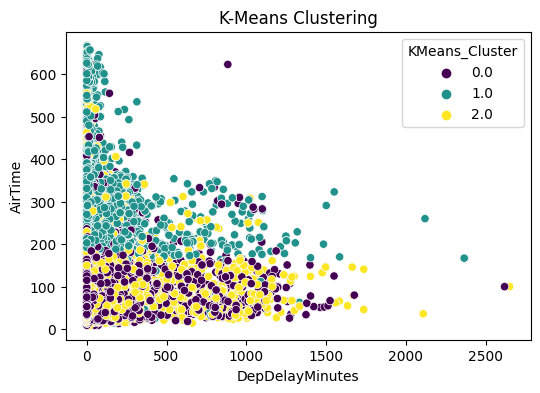

In [ ]:
# Downsample the data
downsampled_df = df.sample(frac=0.1, random_state=42)

# Stage for KMeans clustering
features_for_clustering = downsampled_df.drop(["Cancelled", "Delayed", "Modified", "DepDelayMinutes"], axis=1)
features_for_clustering = features_for_clustering.select_dtypes(['number'])
cleaned_features = features_for_clustering.dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_features)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
cleaned_features['KMeans_Cluster'] = kmeans_labels
clustered_df = pd.merge(downsampled_df, cleaned_features['KMeans_Cluster'], left_index=True, right_index=True, how='left')

# Visualize findings
plt.figure(figsize=(6, 4))
sns.scatterplot(x='DepDelayMinutes', y='AirTime', hue='KMeans_Cluster', data=clustered_df, palette='viridis')
plt.title('K-Means Clustering')
plt.show()

Now we have a general vision of out clusters developed, let's see if there is any relation between them and whether the flight was cancelled or delayed.

In [ ]:
# Print attribute counts per cluster
attribute_counts = clustered_df.groupby('KMeans_Cluster')[['Cancelled', 'Delayed']].sum()
print(attribute_counts.div(attribute_counts.sum(axis=1), axis=0))

                Cancelled   Delayed
KMeans_Cluster                     
0.0              0.026350  0.973650
1.0              0.024455  0.975545
2.0              0.027805  0.972195


The proportion of flights cancelled and delayed in each cluster is approximately the same, which shows that our unsupervised learning failed at finding any relationships between the numerical attributes and whether the flight was cancelled or delayed.

Lastly, we are just going to create an interactive time series graph to show the change of the percent of delayed, cancelled, and total modified flights over time.

In [ ]:
# Create interactive time series graph to show data over time
date_range = pd.date_range('2022-01-01', '2022-07-31', freq='D')
num_days = len(date_range)
temp_df_aggregated = df.groupby('FlightDate')['Cancelled', 'Delayed', 'Modified'].mean()
temp_df_aggregated_melted = pd.melt(temp_df_aggregated.reset_index(), id_vars=['FlightDate'],
                               value_vars=['Cancelled', 'Delayed', 'Modified'],
                               var_name='Attribute', value_name='Average Rates')

fig = px.line(temp_df_aggregated_melted, x='FlightDate', y='Average Rates', color='Attribute',
              title='Average Rates Over Time',
              labels={'Average Rates': 'Average Count', 'FlightDate': 'Flight Date'},
              line_shape='linear')
fig.show()

<ipython-input-51-0354544dcac9>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_df_aggregated = df.groupby('FlightDate')['Cancelled', 'Delayed', 'Modified'].mean()


# **Part VIII:** Conclusion


**In summary:**

1.    We conducted an exploratory data analysis to understand the relationship between various flight data features and the likelihood of flight delays. To do this, we modified our original dataframe to include a new 'Delayed' variable, classifying flights as delayed or not. Our first approach was using a Naive Gaussian Bayes model, which yielded a 72% accuracy in delay classification.
2.    Seeking improvement, we then experimented with a basic neural network (NN). This NN, initially simple with just a few layers, showed promise after a few epochs, reaching an accuracy of 81%. However, upon fine-tuning the model by adjusting the learning rate and adding more layers for complexity, the accuracy slightly decreased to 79%. Interestingly, this model demonstrated a better learning trajectory, starting from 68% accuracy, compared to the initial model's 79% in the first epoch.
3.    We also tried Random Forest Classification on our updated dataframe, which included the 'Delayed' boolean variable. This model achieved a 68% accuracy on the training set. While not exceptionally high, this accuracy was a meaningful baseline, considering the complexities of predicting real-world outcomes like flight delays. We acknowledged the limitations of our approach and considered exploring Gradient Boosting or more advanced deep learning methods in future iterations to potentially enhance accuracy.

**In the future:**

1.   We could have included more datasets which detailed other potential confounding factors, such as the weather conditions of the various airports so we could have further examined if there was a relation between the airport's weather conditions and weather the flight is cancelled or delayed.
2.   In addition, we can further explore the use of more complex neural networks as classification models. These more advanced models could potentially lead to higher accuracy results.

**Overall Experience + Team Reflection:**

1.   This was a great experience to finally apply what we learned in this class without having an outline given to us for what to do. We were able to fully utilize our creativity and delve into a topic and examine relationships using what we learned in the class.
2.    It was an interesting experience to see how different models can give us different accuracies in each scenario and how no singular model will always be the most accurate for each scenario.
3.    It was difficult at times as getting accurate predictions in this case was often more difficult than in class where the models are hand picked for us to get a certain conclusion. This shows how it is much more difficult and different in real life when we are looking for a conclusion and do not have one guaranteed.